<a href="https://colab.research.google.com/github/sundarjhu/UACJ_Jornada2021/blob/main/Espectro_UACJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
__author__ = 'Aida Wofford <awofford@astro.unam.mx>, Sundar Srinivasan <s.srinivasan@irya.unam.mx>'
__version__ = '20210421'
__datasets__ = ['SDSS']  # datasets used in this notebook
__keywords__ = ['UACJ Workshop 2021', 'SDSS', 'spectrum'], # keywords relevant to this notebook

In [10]:
import warnings, numpy as np
warnings.filterwarnings("ignore", category = np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)
try:
  from astroquery.sdss import SDSS
except:
  !pip install astroquery
  from astroquery.sdss import SDSS

     |████████████████████████████████| 6.5MB 6.8MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 3.2MB 50.7MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp37-none-any.whl size=3831874 sha256=2042933a9c8634e1fd741064f20de2395773ce73186783f95b98d40de9219e28
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
Successfully built astroquery


# Análisis del espectro óptico de KISSR 298

## Bajar el espectro de la base de datos del Sloan Digital Sky Survey (SDSS)

INSTRUCCIÓN. Nuestra galaxia se llama KISSR 298. Necesitamos las coordenadas (RA, Dec) o (longitude, latitude) del objeto en el sistema de referencia Equatorial (J2000.0). Encuentra las coordenadas buscando por al objeto por su nombre aquí:
https://ned.ipac.caltech.edu/.
Verifica que las coordenadas del objecto dadas abajo están correctas y de no ser así, modifícalas con los valores que encontraste.

In [11]:
from astropy import coordinates as coords

#We can search by coordinates (in degrees)
RA = 202.457480 #longitude in Equatorial J2000
DEC = 29.579716 #latitude in Equatorial J2000
pos = coords.SkyCoord(str(RA) + 'd ' + str(DEC) + 'd', frame = 'icrs') #units of degrees

#Or we can have the `coords` module automatically look up the coordinates from the name of the source
# Astronomical databases have a "name resolution" service which automatically does this.
# SkyCoord queries the CDS database (http://cdsweb.u-strasbg.fr/) for this.
pos = coords.SkyCoord.from_name("KISSR 298")

#Once the coordinates are known, we search the SDSS archive for spectra of objects around this position.
xid = SDSS.query_region(pos, spectro = True)
plate = xid[0][list(xid.columns).index('plate')]
mjd = xid[0][list(xid.columns).index('mjd')]
fiberID = xid[0][list(xid.columns).index('fiberID')]

# plate = tabla_sdss[0][8] # plate
# mjd = tabla_sdss[0][9] # modified Julian date
# fiberid = tabla_sdss[0][10] # fiberid

# sp = SDSS.get_spectra(matches = xid, plate = 1978, mjd = 53473, fiberID = 371)[0]
sp = SDSS.get_spectra(matches = xid, plate = plate, mjd = mjd, fiberID = fiberID)[0]
#El espectro está en el segundo encabezado del archivo (sp[1])
specdata = sp[1].data

INSTRUCCIÓN. Para bajar el espectro de la base de datos, necesitamos los IDs de la placa, la fecha y la fibra con que se usaron para obtener los datos. Busca el objecto usando las coordenadas en: https://skyserver.sdss.org/dr14/en/tools/chart/chartinfo.aspx. Dále a "Get Image" para ver la imagen del objeto. Puedes cambiar el tamaño de la imagen con los botones de "+" y "-".

INSTRUCCIÓN. Haz click en "Explore" para ir a donde se encuentra el espectro. Abajo a la derecha, en donde dice "Interactive Spectrum", hay una tabla con información sobre las observaciones del objeto. Verifica que la siguiente información es correcta y de no ser así, modifícala.

Importamos los paquetes necesarios.

In [12]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.visualization import quantity_support
quantity_support();  # for getting units on the axes below

Los espectros están en archivos formato fits.

Cargamos los datos y contruimos los vectores de longitudes de onda (wave) , de flujos (flux), y de errores en los flujos (err).

In [13]:
wave = 10**specdata['loglam'] * u.AA # longitud de onda
flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') # flujo
ivar = specdata['ivar']# inverso de la varianza
err = 1 / np.sqrt(ivar) # error * u.Unit('erg cm-2 s-1 AA-1') # error en el flujo

Instalamos el paquete specutils.

In [6]:
# Install a pip package in the current Jupyter kernel if it isn't already installed
!pip install specutils

Vamos a poner los datos en el formato apropiado para "astropy" y crear un objeto llamado "Spectrum1D" que vamos a graficar.

In [7]:
from specutils import Spectrum1D
spec = Spectrum1D(spectral_axis=wave, flux=flux)

ContextualVersionConflict: ignored

Graficamos el espectro.

In [ ]:
f, ax = plt.subplots()  

#ax.step(spec.spectral_axis, spec.flux)
#plt.xlabel('Rest Wavelength ({})'.format(spec.spectral_axis.unit)) 
#plt.ylabel('Flux ({})'.format(spec.flux.unit))
ax.plot(wave, flux)
plt.xlabel('Rest Wavelength (A)') 
plt.ylabel('Flux (cm/s/cm2/A)');

# Corrección por polvo en la Vía Láctea

INSTRUCCIÓN. Vamos a corregir la luz de las estrellas que se encuentran en la galaxia KISSR 298 por extinción debida al polvo en nuestra Galaxia.

Para esto, necesitamos el exceso de color debido al polvo en nuestra Galaxia, en la dirección de KISSR 298. 

Para calcular el exceso de color, E(B-V), primero encuentra la extinción Galáctica en las bandas Landolt B y V, yendo a la liga de abajo, introduciendo el nombre del objeto, luego yendo a la pestaña de Galactic Extinction, y finalmente yendo a la columna "Galactic Extinctions".
https://ned.ipac.caltech.edu/


In [18]:
#Still being tested
#Fetch extinction table from the InfraRed Science Archive's (IRSA) Galactic Dust Reddening and Extinction 
# URL: https://irsa.ipac.caltech.edu/applications/DUST/index.html
from astroquery.irsa_dust import IrsaDust
#Have the `coords` module automatically look up the coordinates from the name of the source 
pos = coords.SkyCoord.from_name("KISSR 298")
table = IrsaDust.get_extinction_table(pos)
#Get the extinction values for the CTIO B and V filters
# This grabs the A_lambda values computed according to the Schlafly & Finkbeiner (2011) prescription,
#     which extends the Cardelli et al. (1989; CCM89) law to longer wavelengths.
A_B = table['A_SandF'][table['Filter_name'] == 'CTIO B'] # extinción Galáctica en la banda B
A_V = table['A_SandF'][table['Filter_name'] == 'CTIO V'] # extinción Galáctica en la banda V
ebvmw = A_B - A_V # exceso de color E(B-V) de la Vía Láctea (Milky Way)
print(ebvmw.quantity)

[0.017] mag


Importamos un paquete necesario.

In [19]:
import sys
# Install a pip package in the current Jupyter kernel if it isn't already installed
try:
  # Import this model: Cardelli, Clayton & Mathis (1989) with A_V = 1 and R_V = 3.1
  from dust_extinction.parameter_averages import CCM89
except:
  !{sys.executable} -m pip install dust_extinction
  # Import this model: Cardelli, Clayton & Mathis (1989) with A_V = 1 and R_V = 3.1
  from dust_extinction.parameter_averages import CCM89

     |████████████████████████████████| 440kB 8.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dust-extinction: filename=dust_extinction-1.0-cp37-none-any.whl size=424649 sha256=847ea2f2087de908773ad18f4e88e5519694eb7d1af843832c97d3dc712793d5
  Stored in directory: /root/.cache/pip/wheels/8f/b4/78/74e5b35146ac5211356853e2b7bcb9074973941a40372f03d5
Successfully built dust-extinction


In [20]:
#from scipy.optimize import curve_fit

# Define the reddening model
ext = CCM89(Rv=3.1)

# Flujo corregido (unextinguished flux )
# uflux = flux / ext.extinguish(1/wave.to(u.micron), Ebv=ebvmw) 
uflux = flux / ext.extinguish(1/wave.to(u.micron), Ebv=0.1) #This should really be Ebv=ebvmw, but has been exaggerated for effect.

Graficamos el espectro antes y después de la corrección por enrojecimiento en la Vía Láctea.

NameError: ignored

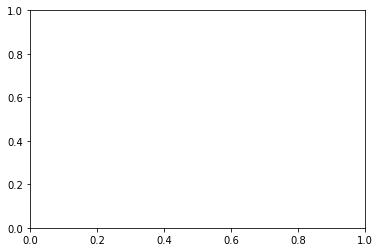

In [21]:
f, ax = plt.subplots()  

ax.step(spec.spectral_axis, spec.flux)
ax.plot(wave,uflux)
plt.xlabel('Observed Wavelength ({})'.format(spec.spectral_axis.unit)) 
plt.ylabel('Flux ({})'.format(spec.flux.unit))
_ = plt.ylim(0,5e-16)

# Corrección por corrimiento al rojo

INSTRUCCIÓN. Determina el corrimiento al rojo, z, de la galaxia.
Para esto, identifica las líneas espectrales de H-alfa y H-beta del hidrógeno. Si la galaxia no se estuviera ni alejando de ni acercando a nostros, las longitudes de onda en Agstroms de estas líneas fuertes del espectro estarían en 6563 y 4861, respectivamente. 

In [24]:
z=0.04899 # Corrimiento al rojo encontrado

#Automatic retrieval using astroquery's ned module
from astroquery.ned import Ned
result_table = Ned.query_object("KISSR 298")
z = result_table['Redshift']

In [ ]:
wave_rest = wave / (1 + z)

Lo graficamos antes y después de la corrección por corrimiento al rojo.

In [ ]:
f, ax = plt.subplots()  

ax.plot(wave, uflux)
ax.plot(wave_rest, uflux)
plt.xlabel('Rest Wavelength ({})'.format(spec.spectral_axis.unit)) 
plt.ylabel('Flux ({})'.format(spec.flux.unit));